# Getting Started

This short tutorial covers a basic use case for {mod}`ott`:

- Compute an optimal transport between two point clouds. This solves a problem that is described by a {class}`~ott.geometry.pointcloud.PointCloud` geometry object (to describe pairwise distances between the points), which is then fed in the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm. 
- Showcase the seamless integration with {mod}`jax`, to differentiate through that OT distance, and plot the gradient flow of that distance, to morph the first point cloud into the second.

## Imports and toy data definition

In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.solvers.linear import sinkhorn

{mod}`ott` is built on top of {mod}`jax`, so we use {mod}`jax` to instantiate all variables. We generate two 2-dimensional random point clouds of $7$ and $11$ points, respectively, and store them in variables `x` and `y`:

In [21]:
rngs = jax.random.split(jax.random.PRNGKey(0), 2)
d, n_x, n_y = 2, 7, 11
x = jax.random.normal(rngs[0], (n_x, d))
y = jax.random.normal(rngs[1], (n_y, d)) + 0.5

Because these point clouds are 2-dimensional, we can use scatter plots to illustrate them.

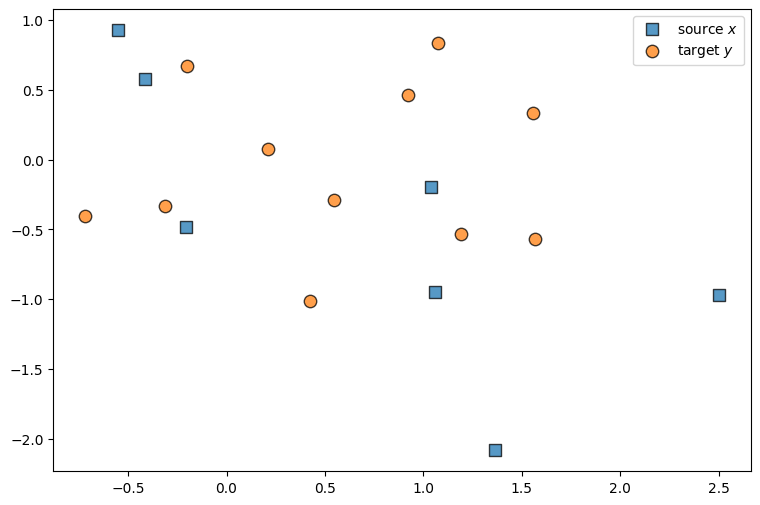

In [4]:
x_args = {
    "s": 80,
    "label": r"source $x$",
    "marker": "s",
    "edgecolor": "k",
    "alpha": 0.75,
}
y_args = {"s": 80, "label": r"target $y$", "edgecolor": "k", "alpha": 0.75}
plt.figure(figsize=(9, 6))
plt.scatter(x[:, 0], x[:, 1], **x_args)
plt.scatter(y[:, 0], y[:, 1], **y_args)
plt.legend()
plt.show()

## Optimal transport with {mod}`ott`

We will now use {mod}`ott` to compute the optimal transport between `x` and `y`. To do so, we first create a `geom` object that stores the geometry (a.k.a. the ground cost) between  `x` and `y`:

In [5]:
geom = pointcloud.PointCloud(x, y, cost_fn=None)

`geom` holds the two datasets `x` and `y`, as well as a `cost_fn`, a function used to quantify a cost between two points. Here, we passed no `cost_fn` and therefore pick the default setting, where the `cost_fn` is {class}`~ott.geometry.costs.SqEuclidean`, the usual squared-Euclidean distance between two points, $c(x,y)=\|x-y\|^2_2$.

In order to compute the optimal transport corresponding to `geom`, we use the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm. The Sinkhorn algorithm will use a regularization hyperparameter `epsilon`, which is typically of the scale of $c(x,y)$ found across point-clouds. For this reason, {mod}`ott` stores that parameter in `geom`, and uses by default the twentieth of the mean cost between all points in `x` and `y`. While it is also possible to set probably weights `a` for each point in `x` (and `b` for `y`), these are uniform by default, here $1/7$ and $1/13$ respectively.

In [9]:
solve_fn = jax.jit(sinkhorn.solve)
ot = solve_fn(geom, a=None, b=None)

As a small note: we have {func}`jitted <jax.jit>` the solver function, and we encourage you to do so whenever possible. This means that the second time the solver is run, it will be much faster, as long as the shapes of `x` and `y` do not vary.

In [12]:
ot = solve_fn(geom)

The output object `ot` contains the solution of the optimal transport problem. This includes the optimal coupling matrix, that indicates at entry `[i, j]` how much of the mass of the point `x[i]` is moved towards `y[j]`.

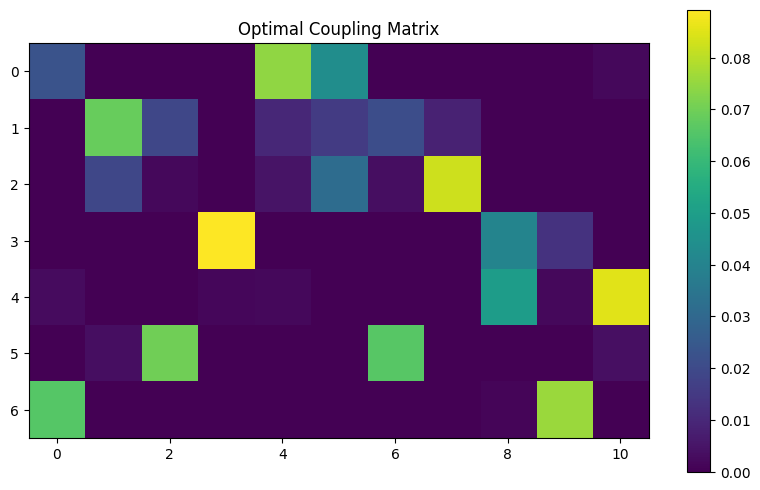

In [13]:
plt.figure(figsize=(10, 6))
plt.imshow(ot.matrix)
plt.colorbar()
plt.title("Optimal Coupling Matrix")
plt.show()

`ot` is a {class}`~ott.solvers.linear.sinkhorn.SinkhornOutput` object that stores many more things, notably a lower, as well as an upper bound of the "true" squared 2-Wasserstein metric between `x` and `y` (the gap between these two bounds can be made arbitrarily small as `epsilon` decreases, when `geom` is instantiated).

In [14]:
print(
    f"2-Wasserstein: Lower bound = {ot.dual_cost:3f}, upper = {ot.primal_cost:3f}"
)

2-Wasserstein: Lower bound = 0.596925, upper = 1.038265


## Automatic differentiation using  {mod}`jax`

We finish this quick tour by illustrating one of the main features of {mod}`ott`: it can be seamlessly integrated into differentiable, end-to-end architectures built using {mod}`jax` (see also {doc}`Hessians`) for an example exploiting implicit differentiation).

We provide a simple use-case where we differentiate the (regularized) OT transport cost w.r.t. `x`,
by defining a wrapper that takes `x` and `y` as input, to output their regularized OT cost.

In [16]:
def reg_ot_cost(x: jnp.ndarray, y: jnp.ndarray) -> float:
    geom = pointcloud.PointCloud(x, y)
    ot = sinkhorn.solve(geom)
    return ot.reg_ot_cost

Obtaining the gradient *function* of `reg_ot_cost` is as easy as making a call to {func}`jax.grad` on `reg_ot_cost`, e.g. `jax.grad(reg_ot_cost)`. 

We use {func}`jax.value_and_grad` below to also store the value of the output itself. Note that by default, `JAX` only computes the gradient w.r.t the *first* of variable of `reg_ot_cost` , here `x`.

In [17]:
# value and gradient *function*
r_ot = jax.value_and_grad(reg_ot_cost)
# evaluate it at `(x, y)`.
cost, grad_x = r_ot(x, y)
assert grad_x.shape == x.shape

`grad_x` is a matrix that has the same size as `x`. Updating `x` with the opposite of that gradient decreases the loss. This process can done iteratively, following a gradient flow, to push `x` closer to `y`.

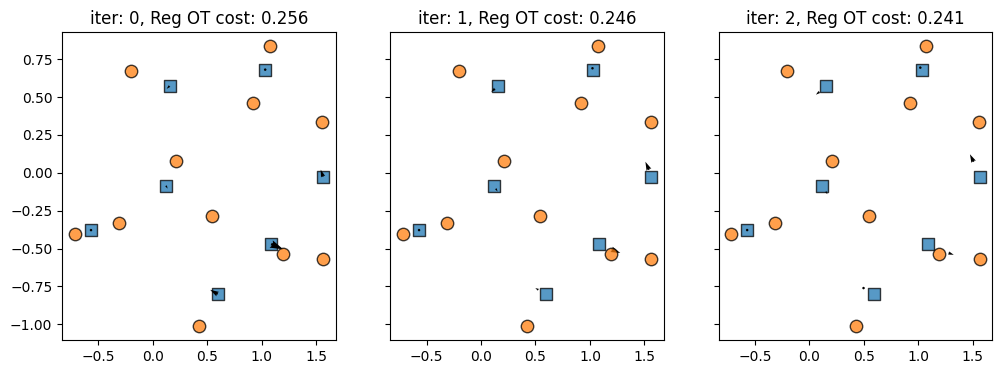

In [29]:
step = 2.0
x_t = x
quiv_args = {"scale": 1, "angles": "xy", "scale_units": "xy", "width": 0.01}
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12, 4))

for iteration, ax in enumerate(axes):
    cost, grad_x = r_ot(x_t, y)
    ax.scatter(x[:, 0], x[:, 1], **x_args)
    ax.quiver(
        x_t[:, 0],
        x_t[:, 1],
        -step * grad_x[:, 0],
        -step * grad_x[:, 1],
        **quiv_args,
    )
    ax.scatter(y[:, 0], y[:, 1], **y_args)
    ax.set_title(f"iter: {iteration}, Reg OT cost: {cost:.3f}")
    x_t -= step * grad_x

# Going further

This tutorial gave you a glimpse of the most basic features of {mod}`ott` and how they integrate with {mod}`jax`.
{mod}`ott` implements many more functionalities, that are described in the following tutorials:
- Seamless integration of other or even custom cost-functions in {doc}`point_clouds`,
- Better performance of {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` solvers using various acceleration techniques in {doc}`One_Sinkhorn`
- Extensions of that approach to {doc}`gromov_wasserstein`, to compare distributions  defined on heterogeneous spaces (for which a `cost_fn` $c(x,y)$ cannot be easily defined).
- {doc}`LRSinkhorn` for faster solvers that constraint coupling matrices (see plot above) to have a low-rank factorization, and exploit low-rank properties of {class}{class}`~ott.geometry.geometry.Geometry` objects, both for the standard OT problem
and its GW variant in {doc}`GWLRSinkhorn`.
- Wasserstein barycenters, as in {doc}`wasserstein_barycenters_gmms` or {doc}`Sinkhorn_Barycenters`,
- Differentiable sorting in {doc}`soft_sort`,
- Neural solvers in {doc}`neural_dual`, to estimate maps in functional form.
- Visual interface to plot progress bars in {doc}`tracking_progress`.